*There are no recommended prerequisites for this notebook, but you may find the first Section of [Modelling](Modelling.ipynb) to be helpful, for some of the exercises.*

In [ ]:
# Run this cell before beginning the exercises.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import os
from typing import Tuple, Callable, Optional, List
from math import isclose
from io import StringIO
import time

# dev note : needs proofreading
# dev note : missing sample solutions for exercises 5 and 7
# dev note : code needs testing on the new environment - Check slack for details on Kats workaround
# dev note : consistency checks required

# The single lens model

To determine the configuration of an event's lens, one must essentially consider models of all possible lens-source configurations and see which ones "match" the observed lightcurve. The collective wisdom of the microlensing community allows for some short cuts in this process. For example, it is atypical to need to consider configuration options beyond a single-lens system with a single source star (1L1S), a single-lens system with two contributing source stars (1L2S), or a binary-lens system with a single source star (2L1S). Considering a higher number of lens objects before thoroughly investigating single- and binary-lensing options has been a pitfall of microlensing in its infancy (KMT-2021-BLG-0322, [Han et al, 2021](https://ui.adsabs.harvard.edu/abs/2021A&A...655A..24H); OGLE-2013-BLG-0723, [Han et al., 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...825....8H) and [Udalski et al., 2015](OGLE-2013-BLG-0723); MACHO 97-BLG-41, [Jung et al., 2013](https://ui.adsabs.harvard.edu/abs/2013ApJ...768L...7J) and [Albrow et al., 2000](https://ui.adsabs.harvard.edu/abs/2000ApJ...534..894A)). Additionally, past experience has informed the notion that dramatic perturbations on the Paczynski curve<sup>*<sub>1</sub></sup> are caused by caustic crossings, which only exist in multiple-lens events. 

> <sup>*<sub>1</sub></sup> The <i>Paczynski curve</i> refers to the shape of a simple microlensing event in which both the lens and the source of are single (not a binary) and effectively point-like.

This section discusses the first point of call for microlensing event modelling; the 1L1S model and the it's parameterisations.

> In addition to this standard model, there are higher-order effects of situational importance, which are discussed in the [Higher Order](HighOrder.ipynb) notebook. The additional effects discussed in that notebbok include:
> + [lens orbital motion](HighOrder.ipynb#lens-orbital-motion),
> + [parallax](HighOrder.ipynb#parallax),
> + [xallarap](HighOrder.ipynb#xallarap),
> + [finite source](HighOrder.ipynb#finite-source), and
> + [stellar variability](HighOrder.ipynb#stellar-variability).

The 1L1S model can be parameterised by $\Theta=(u_0, t_0, t_{\rm E})$, where $u_0$ is the minimum angular separation between the source star and lens mass in units of angular Einstein radius ($\theta_{\rm E}$),<sup>*<sub>2,3</sub></sup> $t_0$ is the time when the source is at position $u_0$, and $t_{\rm E}$ is the time taken for the source star to travel the angular distance $\theta_{\rm E}$. The parameter $t_{\rm E}$ is therefore used in describing the relative angular "velocity," where
$$ \mu_{rel}=\frac{\theta_{\rm E}}{t_{\rm E}}, $$
and $\mu_{rel}$ is referred to as the relative proper motion. In this parameterisation, the source's relative trajectory is described by 
$$ u(t)=(\tau^2+u_0^2)^{(1/2)}, $$
where $\tau=\frac{(t-t_0)}{t_{\rm E}}$.<sup>*<sub>4</sub></sup> For simplicity's sake, microlensing models are usually described in the reference frame of the lens system. This means that, for modelling purposes, the relative velocities of the source and lens systems are attributed to the "source velocity." The total magnification, as a function of the relative position of the source, is described by 
$$ A(u)=\frac{(u^2+2)}{(u\sqrt{(u^2+4)})}. $$

> <sup>*<sub>2</sub></sup> The formulaic description of $\theta_{\rm E}$ can be found in the [Introduction](Introduction.ipynb). We also spent time in this notebook building an intuition as to how different lens and source distances and lens masses affect $\theta_{\rm E}$.

> <sup>*<sub>3</sub></sup> The derivation of $\theta_E$ is shown [here](https://www.microlensing-source.org/tutorial/pspl/).

> <sup>*<sub>4</sub></sup>The derivation of the magnification as a function of $u$ is shown [here](https://www.microlensing-source.org/tutorial/magnification/).


When applying this magnification curve as a model for a lightcurve, the contribution of the source flux, $F_{\rm S}$, and [blended flux, $F_{\rm B}$](https://www.microlensing-source.org/tutorial/blending/)<sup>*<sub>5</sub></sup> must also be determined through linear regression, because the total observed flux for each point in a 1L1S lightcurve is described by
$$ F_i=A_i\times F_{\rm S}+F_{\rm B}; $$
the lensing effect only magnifies flux from the source. 

> <sup>*<sub>5</sub></sup> <i>Blended flux</i> comes from other stars, in the same line of sight, that are attributed to the event's PSF during photometry. This blend flux may be entirely due to the lens, or not at all (in the case of dim lenses, like blackholes)

Finding which $F_{\rm S}$ and $F_{\rm B}$ best generate the data ($\mathbf{F}$), for a given magnification model ($\mathbf{A}$), can be achieved using linear regression. Linear regression is a method used to calculate which model parameters minimise the summed square "distance" of data from a linear model, scaled by the data uncertainties. This minima occurs where the partial differentials of the summed, square distances, scaled by the data uncertainties, equate to zero; i.e.,
$$ \frac{\partial\chi^2}{\partial F_{\rm S}} = 0, $$
$$ \frac{\partial\chi^2}{\partial F_{\rm B}} = 0. $$

> <i>Linear regression considers only the uncertainty-scaled, $y$ distance (flux, in this example) and therefore it is only an appropriate choice of regression method if the $x$ positions are accurate and precise (i.e., negligible $x$ errors).</i>
> <i>Note that a linear model does not mean a model that is a linear line. For example, $ \mathbf{F}=\mathbf{A}\times F_{\rm S}+F_{\rm B} $ is linear even when $\mathbf{A}$ is not.</i>

$\chi^2$ is metric used to describe how likely a parameter set is to have generated the observed data, for a given model. $\chi^2$ requires assumptions of Gaussian-distributed $y$ errors and negligible $x$ errors. It is defined, for this model, as follows:
$$ \chi^2 = \sum\limits_i \frac{\left(F_i - x_i\right)^2} {\sigma_i^2}, $$
where $x_i$ are the photometric, lightcurve data and ${\sigma_i^2}$ are the data uncertainties. The maximum-likelihood solution $(F_{\rm S}, F_{\rm B})$ can therefore be found by solving the following simultaneous equations:
$$ \sum\limits_i \frac{A_i(A_iF_{\rm S}+F_{\rm B}-x_i)} {\sigma_i^2} = 0 $$
$$  \sum\limits_i \frac{(A_iF_{\rm S}+F_{\rm B}-x_i)} {\sigma_i^2} = 0 $$


This problem can be expressed in matrix form as
$$
\begin{matrix}
    \begin{bmatrix}
        \sum\limits_{i}\frac{A_{i}^{2}}{\sigma_{i}^{2}} & 
        \sum\limits_{i}\frac{A_{i}}{\sigma_{i}^{2}} \\ 
        \sum\limits_{i}\frac{A_{i}}{\sigma_{i}^{2}} &
        \sum\limits_{i}\frac{1}{\sigma_{i}^{2}}
    \end{bmatrix}
& \times &
    \begin{bmatrix}
        F_{\rm S} \\ 
        F_{\rm B}
    \end{bmatrix}
&{}={}&
    \begin{bmatrix}
        \sum\limits_{i}\frac{A_{i}x_{i}}{\sigma_{i}^{2}} \\ 
        \sum\limits_{i}\frac{x_{i}}{\sigma_{i}^{2}}
    \end{bmatrix}
\\
\mathbf{B} &\times& \mathbf{\Theta} &=& \mathbf{C}.
\end{matrix}
$$

This is solved as follows:
$$ \mathbf{\Theta} = \mathbf{B}^{-1} \mathbf{C} = \frac{adj\,\mathbf{B}}{\det\mathbf{B}} \cdot \mathbf{C}. $$

<div style="background-color:#e0e0e0; 
    border-left: 8px solid #808080; 
    padding: 10px 0 10px 20px; 
    margin: 20px 5px; 
    box-sizing: border-box"> <a href="./Exercises/SingleLensE1.txt">
    <h2 style="color: #808080; font-size: 24px;">Exercise 1</h2>
    </a>
    <p>Write you own point-source 1S1L magnification model function.</p>
    <br>
</div>

In [9]:
def SL_magnification(u0:float, t0:float, tE:float, t:np.ndarray) -> np.ndarray:
    '''
    Write your doc strings.
    '''
    ######################
    # your code in this cell
    A=0  # place holder so the running this cell does not throw an error
    ######################
    
    return A

> It is good practice to follow this [style guide](https://peps.python.org/pep-0008/) when coding in Python. [This tutorial](https://realpython.com/python-pep8/) gets through it all more efficiently. Astronomy modules, written in Python, typically follow the [Numpy style](https://numpydoc.readthedocs.io/en/latest/format.html) for doc string.

Lets generate a fake data set using your function.

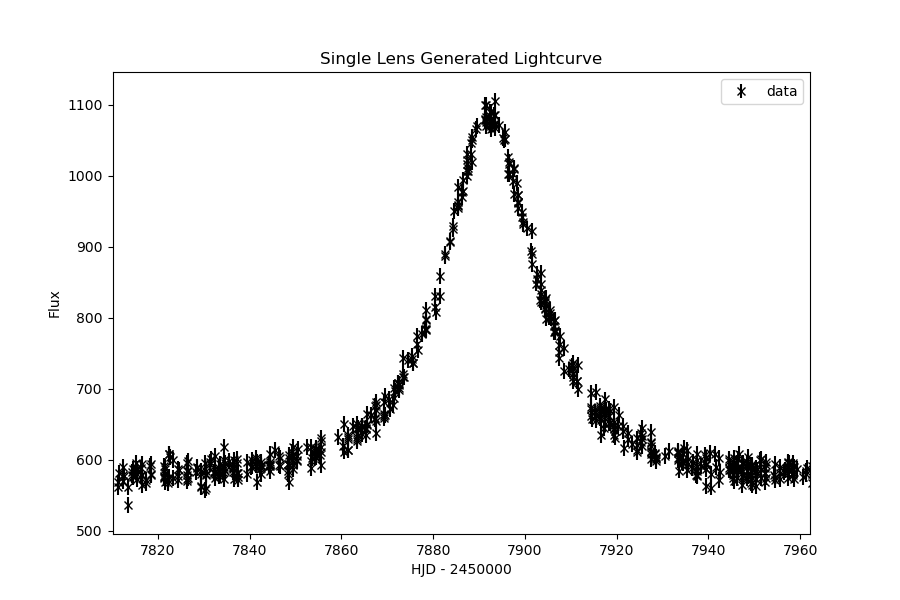

In [ ]:
def generate_lightcurve(SL_magnification: Callable[[float, float, float, np.ndarray], np.ndarray], 
                        u0: float, t0: float, tE: float, FS: float, FB: float, sig: np.ndarray, 
                        t: Optional[np.ndarray] = None, 
                        trange: Optional[Tuple[float, float]] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate lightcurve for given parameters and epochs or date range.
    
    Parameters
    ----------
    SL_magnification : Callable[[float, float, float, np.ndarray], np.ndarray]
        Single lens magnification function.
    u0 : float
        Impact parameter.
    t0 : float
        Time of closest approach.
    tE : float
        Einstein radius crossing time.
    FS : float
        Source flux.
    FB : float
        Blend flux.
    sig : np.ndarray
        Standard deviation of Gaussian errors.
    t : Optional[np.ndarray], optional
        Array of epochs (default is None).
    trange : Optional[Tuple[float, float]], optional
        Date range (default is None).
        - tstart : float, start of date range.
        - tfinish : float, end of date range.
    
    Returns
    -------
    t_data : np.ndarray
        Generated time points.
    flux_data : np.ndarray
        Generated flux data with noise.
    flux_err_data : np.ndarray
        Gaussian errors.

    Raises
    ------
    ValueError
        If neither epochs nor date range is provided.
    """
    
    # Generate epochs if not provided
    if t is None:
        if trange is None:
            raise ValueError('Either epochs or date range must be provided.')
        tstart, tfinish = trange
        days = np.arange(np.floor(tstart), np.ceil(tfinish)) # Generate integer days within the range
        t = []
        for day in days:
            if tstart <= day <= tfinish:
                # Generate epochs for the night
                num_epochs = np.random.randint(0, 9)  # Random number of epochs between 0 and 8
                epochs = np.random.choice(np.arange(0.3, 0.6, 0.0104167), size=num_epochs, replace=False)
                t.extend(day + epochs)
    t = np.array(t)
    
    # Generate theoretical flux
    A = SL_magnification(u0, t0, tE, t)
    flux_theoretical = A*FS + FB
    
    # Generate Gaussian noise
    noise = np.random.normal(0, sig, size=t.shape)
    
    # Generate noisy flux data
    flux_data = flux_theoretical + noise
    
    # Gaussian errors
    flux_err_data = np.full(t.shape, sig)
    
    return t, flux_data, flux_err_data
    

# making up event parameters and data stats
sig = 11.2
u0 = 0.4321
t0 = 7892.123
tE = 23.4
FS = 343.21
FB = 231.2

trange = (t0-82, t0+70)

# generating fake data
t_data, flux_data, flux_err_data = generate_lightcurve(SL_magnification, 
                                                       u0, t0, tE, FS, FB, 
                                                       sig, trange=trange)

%matplotlib widget

# Let's start by taking a look at the data
plt.close(1)
plt.figure(figsize=(9,6), num=1)
plt.errorbar(t_data, flux_data, yerr=flux_err_data, fmt='x', color='black', label='data')
plt.xlabel('HJD - 2450000')
plt.ylabel('Flux')
plt.title('Single Lens Generated Lightcurve')
plt.xlim(trange[0], trange[1])
plt.legend()
plt.show()



Below is a function to solve for $F_{\rm S}$ and $F_{\rm B}$.

In [4]:
def calc_Fs(model: np.ndarray, x: np.ndarray, sig2: np.ndarray) -> Tuple[float, float]:
    '''
    Solves for the flux parameters for a given model using least squares.
    
    Parameters
    ----------
    model : np.ndarray
        Model magnification curve.
    x : np.ndarray
        Observed flux values.
    sig2 : np.ndarray
        Flux errors.
    
    Returns
    -------
    FS : float
        Source flux.
    FB : float
        Blend flux.
    '''
    #A
    A11 = np.sum(model**2 / sig2)
    Adiag = np.sum(model / sig2) 
    A22 = np.sum(1.0 / sig2)
    A = np.array([[A11,Adiag], [Adiag, A22]])
     
    #C
    C1 = np.sum((x * model) / sig2)
    C2 = np.sum(x / sig2)
    C = np.array([C1, C2]).T
     
    #B
    B = np.linalg.solve(A,C)
    FS = float(B[0])
    FB = float(B[1])
    
    return FS, FB

Okay, now let try fitting our lightcurve.

<div style="background-color:#e0e0e0; 
    border-left: 8px solid #808080; 
    padding: 10px 0 10px 20px; 
    margin: 20px 5px; 
    box-sizing: border-box"> <a href="./Exercises/SingleLensE2.txt">
    <h2 style="color: #808080; font-size: 24px;">Exercise 2</h2>
    </a>
    <p>Make an initial guess at your microlensing parameters (<i>p</i><sub>0</sub>). Don't stress about this too much. It's a guess; it doesn't have to be <i>that</i> good.</i></p>
    <p><ul>
        <li> <i>t<sub>0</sub></i> is the time of the peak of the event, </li>
        <li> <i>u<sub>0</sub></i> is somewhere probably between 0 and 1, if there is an observable packzynki curve, </li>
        <li> <i>t</i><sub>E</sub> is the width of the Packzynski curve and is typically 10-30 days. </li>
    </p>
    <br>
</div>

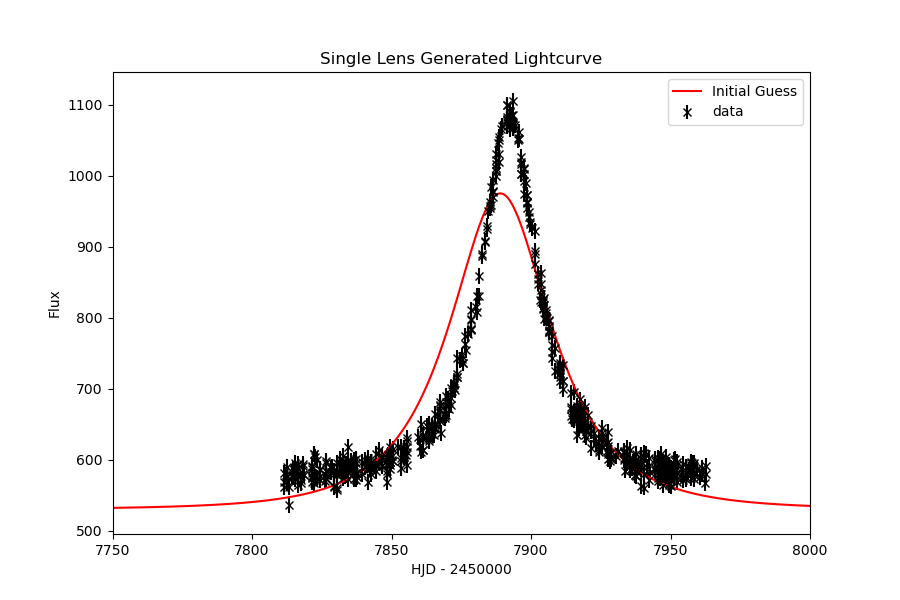

In [ ]:
######################
# Initial guess
#u0 = 
#t0 = 
#tE = 
######################

# magnification model for initial guess chi2
A_0 = SL_magnification(u0, t0, tE, t_data)

# Model
t_model = np.linspace(7750, 8000, 1000)
A_model = SL_magnification(u0, t0, tE, t_model)

p0 = [u0, t0, tE]
FS0, FB0 = calc_Fs(A_0, flux_data, flux_err_data**2)

# Plot the data and guess
plt.close(2)
plt.figure(figsize=(9,6), num=2)
plt.errorbar(t_data, flux_data, yerr=flux_err_data, fmt='x', color='black', label='data')
plt.plot(t_model, FS0*A_model + FB0, color='red', label='Initial Guess')
plt.xlabel('HJD - 2450000')
plt.ylabel('Flux')
plt.title('Single Lens Generated Lightcurve')
plt.xlim(7750, 8000)
plt.legend()
plt.show()


<div style="background-color:#e0e0e0; 
    border-left: 8px solid #808080; 
    padding: 10px 0 10px 20px; 
    margin: 20px 5px; 
    box-sizing: border-box"> <a href="./Exercises/SingleLensE3.txt">
    <h2 style="color: #808080; font-size: 24px;">Exercise 3</h2>
    </a>
    <p>Write an <a href="https://en.wikipedia.org/wiki/Mathematical_optimization#Optimization_problems">objective function</a> for the fit.</p>
    <br>
</div>

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0
             x: [ 7.000e-01  7.889e+03  3.000e+01]
           nit: 23
          nfev: 114
 final_simplex: (array([[ 7.000e-01,  7.889e+03,  3.000e+01],
                       [ 7.000e-01,  7.889e+03,  3.000e+01],
                       [ 7.000e-01,  7.889e+03,  3.000e+01],
                       [ 7.000e-01,  7.889e+03,  3.000e+01]]), array([ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00]))


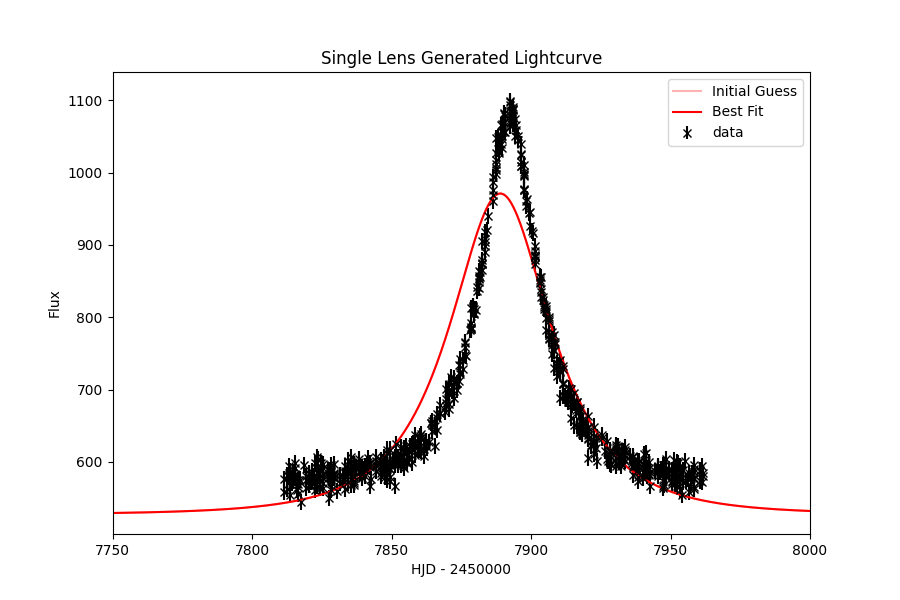

In [14]:
def chi2(p: List[float], t: np.ndarray, f: np.ndarray, sig: np.ndarray,
         SL_magnification: Callable[[float, float, float, np.ndarray], np.ndarray]
         ) -> float:
    '''
    Calculates the chi squared value for a given model and parameters.
    
    Parameters
    ----------
    p : np.ndarray
        Parameters.
    t : np.ndarray
        Data epochs.
    f : np.ndarray
        Observed flux values.
    sig : np.ndarray
        Flux errors.
    
    Returns
    -------
    chi2 : float
        Chi squared value.
    '''

    ######################
    # your chi2 calculation goes here
    chi2_value = 0
    ######################

    return chi2_value


# Minimize the chi squared value
result = minimize(chi2, p0, 
                  args=(t_data, flux_data, flux_err_data, SL_magnification), 
                  method='Nelder-Mead')
popt = result.x
print(result)

# Model
A_model_opt = SL_magnification(popt[0], 
                               popt[1], 
                               popt[2], 
                               t_model)  # model line for best fit parameters
A_opt = SL_magnification(popt[0], 
                         popt[1], 
                         popt[2], 
                         t_data)  # model flux values for best fit parameters
FS_opt, FB_opt = calc_Fs(A_opt, 
                         flux_data, 
                         flux_err_data**2)  # best fit flux parameters

# Plot
plt.close(3)
plt.figure(figsize=(9,6), num=3)

plt.errorbar(t_data, flux_data, 
             yerr=flux_err_data, 
             fmt='x', color='black', label='data')
plt.plot(t_model, FS0*A_model + FB0, 
         color='red', label='Initial Guess', alpha=0.3)
plt.plot(t_model, FS_opt*A_model_opt + FB_opt, 
         color='red', label='Best Fit')

plt.xlabel('HJD - 2450000')
plt.ylabel('Flux')
plt.title('Single Lens Generated Lightcurve')
plt.xlim(7750, 8000)
plt.legend()
plt.show()

Great job! 

Did you get fit parameters similar to those you put in to the *generate_lightcurve()* function?

If not, maybe you should take another look at you $\chi^2$ function.

If your fit looks good, let try and quantify how much better it was than the initial guess. Given the assumptions we mentioned earlier out Gaussianity and on-dimensional data uncertainties, the relative probability that our model produced the data is

$$ \mathcal{L} = e^{-\Delta\chi^2/2}. $$

<div style="background-color:#e0e0e0; 
    border-left: 8px solid #808080; 
    padding: 10px 0 10px 20px; 
    margin: 20px 5px; 
    box-sizing: border-box"> <a href="./Exercises/SingleLensE4.txt">
    <h2 style="color: #808080; font-size: 24px;">Exercise 4</h2>
    </a>
    <p>How much more probable is it that your fitted parameters produced the lightcurve than your initial guess parameters?</p>
    <br>
</div>


In [15]:
######################
# Do your calculation here
######################

Let try that again with some real data.

In [16]:
def mag2flux(mag: np.ndarray, 
             zp: Optional[float] = 25.0
             ) -> np.ndarray:
    '''
    Converts magnitude values (array) to flux.
    
    Parameters
    ----------
    mag : np.ndarray
        Array of magnitudes.
    zp : float, optional
        Zero point of the magnitude system (default is 25.0).

    Returns
    -------
    f : np.ndarray
        Array of fluxes.
    '''
    f = 10.0**((mag - zp) / -2.5)
    return f

def mag2flux_err(mag: np.ndarray, mag_err: np.ndarray, 
                 zp: Optional[float] = 25.0):
    '''
    Converts magnitude values and errors (array) to flux using error propagation formula.
    
    Parameters
    ----------
    mag : np.ndarray
        Array of magnitudes.
    mag_err : np.ndarray
        Array of magnitude errors.
    zp : float, optional
        Zero point of the magnitude system (default is 25.0).

    Returns
    -------
    flux_err : np.ndarray
        Array of flux errors.
    '''
    dfdmag = -0.4 * np.log(10) * 10.**(0.4*(zp-mag))
    flux_err = np.sqrt(dfdmag**2 * mag_err**2)
    return flux_err

# Data directory
data_dir = os.path.abspath('./Data/Events/OB170002/')

def read_data(data_dir: str, 
              extension: Optional[List[str]] = ['dat','diapl','pysis','txt']
              ) -> dict:
    '''
    Reads in the data from a directory.
    
    Parameters
    ----------
    dir : str
        Directory path.
    
    Returns
    -------
    data : dict
        Dictionary containing the data.
        Keys are observatory names, and values are tuples of (t_data, flux_data, flux_err_data).
            t_data : np.ndarray
                Time data.
            mag_data : np.ndarray
                Magnitude data.
            mag_err_data : np.ndarray
                Magnitude error data.
    '''
    data = {} # initalizing data dictinary

    # list of all the 'dat' files in data_directory
    files = [f for f in os.listdir(data_dir) if f.split('.')[-1] in extension] 

    print(files)
    
    files.sort() # alphabetise the data files

    for f in files:

        # creating the path to each data file
        if data_dir[-1] == '/':
            datafile = data_dir + f
        else:
            datafile = data_dir + '/' + f

        # Reading in the data
        t_data = np.loadtxt(datafile, usecols=0)
        if t_data[0] > 2450000:
            t_data = t_data - 2450000
        mag = np.loadtxt(datafile, usecols=1)
        mag_err = np.loadtxt(datafile, usecols=2)

        # This only works because there is only one KMT field (42)
        if 'OGLE' in f:  # (HJD, mag, mag_err, quality?, sky counts?)
            observatory = 'OGLE'
            flux_data = mag2flux(mag, zp=28.)
            flux_err_data = mag2flux_err(mag, mag_err, zp=28)
        if 'KMT' in f:
            flux_data = mag2flux(mag, zp=28.)
            flux_err_data = mag2flux_err(mag, mag_err, zp=28.65)
            
            if 'KMTA' in f:  # (HJD, mag, mag_err)
                observatory = 'KMT-A'
            elif 'KMTC' in f:
                observatory = 'KMT-C'
            elif 'KMTS' in f:
                observatory = 'KMT-S'

        data[observatory] = (t_data, flux_data, flux_err_data)
    
    return data

data = read_data(data_dir)

print(data)

['KMTS42_I.txt', 'OGLE-2017-BLG-0002.txt', 'KMTA42_I.txt', 'KMTC42_I.txt']
{'KMT-A': (array([7806.24415, 7806.25732, 7806.26931, ..., 7937.1415 , 7937.16061,
       7937.18001]), array([ 9718.5170294 , 10984.99845058, 10568.17509214, ...,
        8425.5837534 ,  8472.27414141,  9341.14255736]), array([354.1075771 , 361.40651699, 321.30165513, ..., 461.20272052,
       363.79339135, 390.76914175])), 'KMT-C': (array([7805.87179, 7805.88926, 7806.859  , ..., 7938.52161, 7938.55645,
       7938.57627]), array([10854.25449307, 10914.40336449, 10461.64551022, ...,
        8150.79555612,  8472.27414141,  8135.79505605]), array([326.54281547, 321.94993952, 267.91623672, ..., 316.93022935,
       302.73517188, 304.07487934])), 'KMT-S': (array([7808.59108, 7808.60346, 7808.61802, ..., 7937.56534, 7937.59386,
       7938.23454]), array([ 9826.5258283 ,  9853.71506859, 10214.0975199 , ...,
        8218.64080389,  8425.5837534 ,  7827.08409591]), array([341.73839946, 255.32019627, 260.54955302, ...

If you plot this data, you may find that the KMTNet data are full of "bad data" that are not reasonable and will have an affect on the fit. This kind of data would warrant a more careful rereduction or filtering based on image quality metrics. In lue of any such image quality data or access to the raw images, we could remove those data with the greatest uncertainties, to make our plots look nicer for these excercises, but this procedure is considerd bad practice for statistical analysis. Faced with this same problem in your work, you could consider "fitting" the bad data removal so as to marginalize their effect and provide statistical grounds for the pruning selection. Refer to the Pruning Outliers section on page 11 of [Hogg, Bovy & Lang (2010)](https://arxiv.org/pdf/1008.4686).

<div style="background-color:#e0e0e0; 
    border-left: 8px solid #808080; 
    padding: 10px 0 10px 20px; 
    margin: 20px 5px; 
    box-sizing: border-box"> <a href="./Exercises/SingleLensE5.txt">
    <h2 style="color: #808080; font-size: 24px;">Exercise 5</h2>
    </a>
    <p>Fit a point-source 1S1L model to event OB170002?</p>
    <br>
    <p><i>Note that each data set requires individual F</i><sub>S</sub><i> and F</i><sub>B</sub><i> parameters in order to be comparable to the unifying magnification curve, which is borne of the physical, lensing configuration and thus is not data set specific.</i></p>
    <br>
    <p><i>Here, "data set" refers to lightcurve data, for a given event, reduced using the same method, from the same observatory and field, imaged in the same band.</i></p>
    <br>
</div>

In [17]:
######################
# Your code here
######################

You can find further point-source exercises [here](https://www.microlensing-source.org/concept/point-lenses/).

## Free single-lens-fitting codes

If data fitted to a point source 1L1S model shows signs of deviations from the model, a binary lens, binary source, and/or higher-order effect model needs to be considered in an attempt to describe these deviations.

While creating a 1S1L function is a fairly trivial process, these more complicated models are not. It is usefull to be familiar with the freely available codes one can employ to fit such models. 

Open source single-lens codes:
| Name | Notes | Maintained | Link |
| :-: | :-: | :-: | :-: |
| MuLens | User friendly, single- and binary-lens fitting code | Yes ([Poleski](https://github.com/rpoleski)) | [GitHub](https://github.com/rpoleski/MulensModel) |
| BAGEL | Incorporates photometric and astrometric microlensing | Yes ([Moving Universe Lab](https://github.com/MovingUniverseLab)) | [GitHub](https://github.com/MovingUniverseLab/BAGLE_Microlensing)
| VBMicroelensing | A more general version of the binary-lens code [VBBL](https://github.com/valboz/VBBinaryLensing) | Yes ([Bozza](https://github.com/valboz)) | [GitHub](https://github.com/valboz/VBMicrolensing) |
| pyLIMA | Useful for space-based observations | Yes ([Bachelet](https://github.com/ebachelet)) | [GitHub](https://github.com/ebachelet/pyLIMA) |
| RTModel | Hands-off model fitting with built in model *"interpretation"* (e.g. determing single-lens vs binary-lens arrangement) | Yes ([Bozza](https://github.com/valboz)) | [Github](https://github.com/valboz/RTModel) |
| muLAn | Designed for Roman data (space-based observations) | No ([Cassan](https://github.com/ArnaudCassan)/[Ranc](https://github.com/clementranc)) | [GitHub](https://github.com/muLAn-project/muLAn) |

<br>

> <i>If you would like to add your code to this list, please email the corresponding author, details in the `ReadMe.md` file.</i>

As an example, lets use [MuLens]() to create a 1L1S model magnification curves with finite source effects (i.e., a finite-source 1L1S model). 

> <i>The different options available for methods of calculating the finite-source magnification are described in this [document](https://github.com/rpoleski/MulensModel/blob/master/documents/magnification_methods.pdf).</i>

First off lets install the module. Execute the following code in your terminal, with your environment activated:

```bash
(TheGuide) ~/$ pip install MulensModel
```

If that worked you should be able to run the following code without error. You may need to restart the notebook kernel.

> <i>These microlensing codes are not on conda-forge (which requires binary packages of compiled code), so they must be installed from source (e.g., using [**pip**](https://pip.pypa.io/en/stable/)) as opposed to `conda install MulensModel`.</i>

In [7]:
import MulensModel

The following code shows how we can use MulensModel to calculate a more complex magnification model without much extra effort. However, our choice of magnification method is not without consequence. We recommend you work through the [Higher-Order Effects](HigherOrderEffect.ipynb) notebook to understand the different choices.

> <i> There is a bug in MulensModel regarding a missing table. This issue has been raised on github and we are awaiting resolution.</i>

ValueError: File with FSPL data does not exist.
/opt/anaconda3/envs/TheGuide-P312defaults/lib/python3.12/site-packages/MulensModel/data/interpolation_table_b0b1_v3.dat

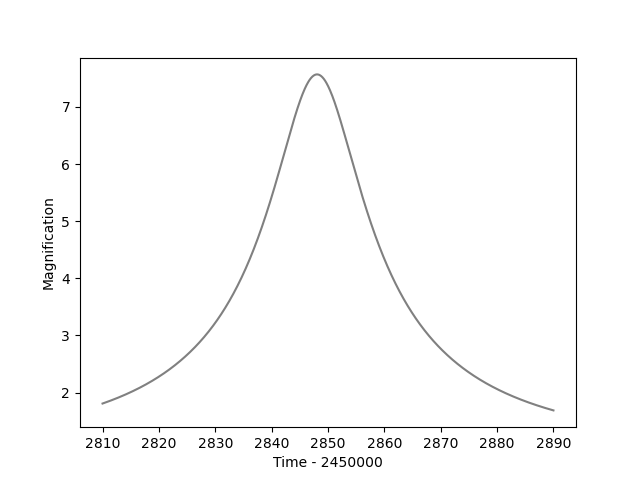

In [8]:
# Define a point source, point lens model
pspl = MulensModel.Model({'t_0': 2452848.06, 'u_0': 0.133, 't_E': 61.5})

# Define a finite source, point lens model
fspl = MulensModel.Model({'t_0': 2452848.06, 'u_0': 0.133, 't_E': 61.5, 'rho': 0.1}, )

# Plot the magnification curve:
plt.close(10)
plt.figure(10)
pspl.plot_magnification(
    t_range=[2452810, 2452890], subtract_2450000=True, color='grey', 
    linestyle='-', label='PSPL')

# calculate the magnification curve using a finite source model
fspl.set_magnification_methods([2450000., 'finite_source_uniform_Gould94', 2470000.])  # rho <= 0.1
fspl.plot_magnification(
    t_range=[2452810, 2452890], subtract_2450000=True, color='red', 
    linestyle=':', label='FSPL Gould94')

plt.legend()
plt.show()

Below is some code for creating a figure with corresponding trajectory and magnification curve subplots.

<div style="background-color:#e0e0e0; 
    border-left: 8px solid #808080; 
    padding: 10px 0 10px 20px; 
    margin: 20px 5px; 
    box-sizing: border-box"> <a href="./Exercises/SingleLensE6.txt">
    <h2 style="color: #808080; font-size: 24px;">Exercise 6</h2>
    </a>
    <p>Add the corresponding magnification curve into the figure using the <i>get_magnification()</i> function. This function is an attribute of the MulensModel.Model object. It takes an array of epochs as its inputs and outputs an array of corresponding magnifications of the same size.</p>
    <br>
</div>

In [20]:

def get_trajectory(u0, alpha, xlims, ylims, n=1000):

    phi = alpha + np.pi/2.0  # angle of u0 vector
    #phi = alpha - np.pi/2.0  # to swap the direction of u0

    #dealing with extreme cases
    if isclose(alpha, 0.0, abs_tol=1e-8):  # left to right
        xs = [-np.inf, np.inf]
        ys = False
        mt = 0
        c = u0*np.sin(phi)
    elif isclose(alpha, np.pi, abs_tol=1e-8) or isclose(alpha, -np.pi, abs_tol=1e-8):  # right to left
        xs = [-np.inf, np.inf]
        ys = False
        mt = 0
        c = u0*np.sin(phi)
    elif isclose(alpha, np.pi/2.0, abs_tol=1e-8) or isclose(alpha, -3.0*np.pi/2.0, abs_tol=1e-8):  # top to bottom
        ys = [-np.inf, np.inf]
        xs = False
        mt = -np.inf
        c = None
    elif isclose(alpha, -np.pi/2.0, abs_tol=1e-8) or isclose(alpha, 3.0*np.pi/2.0, abs_tol=1e-8):  # bottom to top
        ys = [-np.inf, np.inf]
        xs = False
        mt = np.inf
        c = None
    elif isclose(alpha, -2.0*np.pi, abs_tol=1e-8) or isclose(alpha, 2.0*np.pi, abs_tol=1e-8):  # left to right
        xs = [-np.inf, np.inf]
        ys = False
        mt = 0
        c = u0*np.sin(phi)

    #normal cases
    else:
        #common trajectory elements
        mt = np.sin(alpha)/np.cos(alpha)  # gradient of the trejectory line
        mu0 = -1.0/mt  # gradient of the u0 vector (normal to the trajectory)

        # c is the y intercept of the trajectory
        c = u0*np.sin(phi) - mt * u0*np.cos(phi)  # c = y - mx
                                                  # x = (y-c)/m

        if (mt >= -1.0) and (mt <= 1.0): # more across than up and down
            xs = [(ylims[0]-c)/mt,(ylims[1]-c)/mt]  # min and max on plot but don't know 
                                                    # which is which
            ys = False
        else:  # more up and down than across
            ys = [mt*xlims[0]+c, mt*xlims[1]+c]  # y = mx + c
            xs = False

    #trajectory points
    if c is None:
        y = np.linspace(ylims[0], ylims[1], n)  # the order doean't matter. 
                                                # I sort it out elsewhere
        x = y*0.0 + u0*np.cos(phi)  # y*0.0 is to make sure x is an array like y
    elif not(ys):
        #plot bounds for the trajectories       
        xmin = np.max([xlims[0],np.min(xs)])  # must be in a list or np.min and np.max shit
        xmax = np.min([xlims[1],np.max(xs)])  # the bed
        print('xmin:', np.max([xlims[0],np.min(xs)]), xlims[0], np.min(xs))
        print('xmin:', np.min([xlims[1],np.max(xs)]), xlims[0], np.max(xs))

        x = np.linspace(xmin, xmax, n)
        y = mt*x+c
    elif not(xs):
        #plot bounds for the trajectories       
        ymin = np.max([ylims[0],np.min(ys)])  # must be in a list or np.min and np.max shit
        ymax = np.min([ylims[1],np.max(ys)])  # the bed
        print('ymin:', np.max([ylims[0],np.min(ys)]), xlims[0], np.min(ys))
        print('ymax:', np.min([ylims[1],np.max(ys)]), xlims[0], np.max(ys))

        y = np.linspace(ymin, ymax, n)
        x = (y-c)/mt

    return x, y

def get_t0(x, y, t):
    '''finds the t values for the "epoch" with the closest approach to the COM. 
    Note that this "t0" isn't ecaxtly t0, but it is good enough for demonstrative plots.'''
    
    u = np.sqrt(x**2 + y**2)  # directionless distance from the origin (COM)
    u0_index = np.argmin(u)  # epoch with the smallest u
    t0 = t[u0_index]  # t at u_min

    return t0

def get_t(x, y, alpha):
    '''finds arbitraty t set, corresponding to x and y coordinates, using alpha to determine
    which side the trajectory starts from. This function avoid what should be negative 
    t values ending up positive, creating a fold in the magnification curve.'''
    
    alpha = alpha%(2.0*np.pi)

    #delta x
    if (alpha >= -np.pi/2.0) and (alpha <= np.pi/2.0):
        x1 = np.min(x)
    else:
        x1 = np.max(x)
    dx = x - x1

    if ((0.0 <= alpha)  and (alpha <= np.pi)) or ((-2.0*np.pi <= alpha) and (alpha <= -np.pi)):
        y1 = np.min(y)
    else:
        y1 = np.max(y)
    dy = y - y1

    dt = np.sqrt(dx**2+dy**2)

    return dt

xmin: -2.0 -2.0 -inf
xmin: 2.0 -2.0 inf
xmin: -2.0 -2.0 -inf
xmin: 2.0 -2.0 inf
xmin: -2.0 -2.0 -inf
xmin: 2.0 -2.0 inf
xmin: -2.0 -2.0 -inf
xmin: 2.0 -2.0 inf


/tmp/ipykernel_18035/643147540.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()  # u0=...


(-2.0, 2.0)

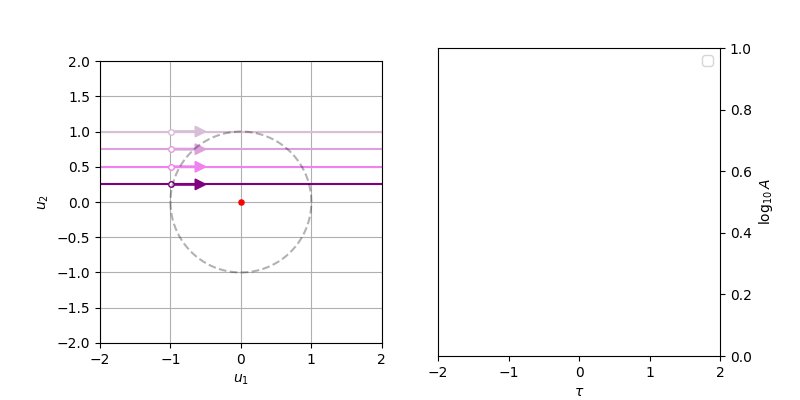

In [23]:
# Finite source
rho = 0.1  # source radius in units of theta_E
rho_index = int(1000/4) # for adjusting the location of the source markers in the trajectory plot

# Seting up a MulensModel object
fspl = MulensModel.Model({'t_0': 0, 'u_0': 1, 't_E': 1, 'rho': rho})  # the parameters here don't matter - we will 
                                                                      # change them later
                                                                      
# Setting the limbdarkened-source magnification method, based on the source size
if rho <= 0.1:
    fspl.set_magnification_methods([2450000., 'finite_source_LD_Yoo04', 2470000.])
elif rho >= 2.0:
    fspl.set_magnification_methods([2450000., 'finite_source_LD_Lee09', 2470000.])
else:
    fspl.set_magnification_methods([2450000., 'finite_source_LD_WittMoa94', 2470000.])

tE = 1.0  # t is in units of tE instead of days
# Theta (parameter list: [t0, u0, tE, rho])
parameters_to_fit = ["t_0", "u_0", "t_E", "rho"]

# Plot bounds
xlims = (-2.0,2.0)
ylims = (-2.0,2.0)

t_len = 0.5 # length of the trajectory direction arrow
alpha = 0.0  # trajectory direction

trajectories = [
    {'color': 'purple', 'u0': 0.25},
    {'color': 'violet', 'u0': 0.5},
    {'color': 'plum', 'u0': 0.75},
    {'color': 'thistle', 'u0': 1.0}
]

trajectories_df = pd.DataFrame(trajectories)

# Plotting
plt.close(11)
fig, ax = plt.subplots(1, 2, figsize=(8, 4), num=11)

# Trajectories
for i in trajectories_df.index:
    trajectory = dict(trajectories_df.loc[i])
    u1, u2 = get_trajectory(trajectory['u0'], alpha, xlims, ylims)
    t= get_t(u1, u2, alpha) 
    t0 = get_t0(u1, u2, t)
    tt = t-t0
    Theta = [t0, trajectory['u0'], tE, rho]

    # Plot components
    ax[0].plot(u1, u2, marker='', ls='-', c=trajectory['color'])  # trajectories
    ax[0].plot(u1[rho_index], u2[rho_index], marker='o', markerfacecolor='white'\
            , markeredgecolor=trajectory['color'], ms=rho*40)  # source sizes
    
    # Trajectory direction arrows
    ax[0].arrow(u1[rho_index], u2[rho_index], t_len*np.cos(alpha), t_len*np.sin(alpha)\
            , head_width=0.15, head_length=0.15, length_includes_head=True, width=0.02\
            , color=trajectory['color'])
    
    # Updatting the mulens model object with the new parameters
    for i, parameter in enumerate(parameters_to_fit):
        setattr(fspl.parameters, parameter, Theta[i])  
    
    # Magnification curve array
    # Your code here!!

    # Plot lightcurves (technically, manification curves)
    # Your code here!!

# Aesthetics
ax[0].grid(True)
ax[0].set_aspect('equal')  # Equal in x and y
#ax[1].set_aspect(6.7)  # manually forcing the magnification curve to be the same 
                        # size as the caustic diagram

ax[0].set_ylabel(r'$u_{2}$')  # axis labels
ax[0].set_xlabel(r'$u_{1}$')
ax[1].set_ylabel(r'$\log_{10}A$')
ax[1].set_xlabel(r'$\tau$')
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()

ax[1].legend()  # u0=...

phi = np.linspace(-np.pi,np.pi,200)
r = 1  # theta_E
# r^2 = x^2 + y^2
x = r * np.cos(phi)
y = r * np.sin(phi)
ax[0].plot(x, y, 'k--', alpha=0.3)  # thetaE circle
ax[0].plot(0, 0, marker='o', c='red', ms=np.log10(5000.0))  # lens object

ax[0].set_xlim(xlims[0],xlims[1])  # set plot bounds
ax[0].set_ylim(ylims[0],ylims[1])
ax[1].set_xlim(xlims[0],xlims[1])

# Save
#plt.savefig('/Products/single_trajectories_FS.png', bbox_inches='tight')  # 'tight' removes outer padding

The Mulens class has built in data storage and event grouping objects and a $\chi^2$ calculating function. We could use this functionality to fit a finite source model to OB170002 as seen in the [Mulens fitting example](https://github.com/rpoleski/MulensModel/blob/master/examples/example_02_fitting.py).

We can add our data to a MulensData object as follows:

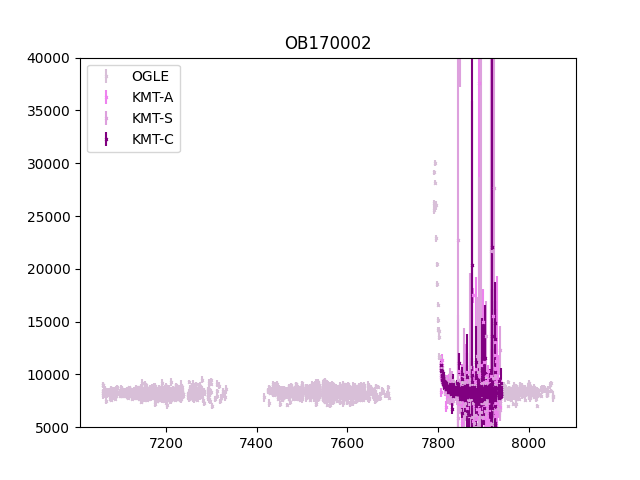

In [24]:
OB170002_KMTC_data = MulensModel.MulensData(data_list = data['KMT-C'], 
                                            plot_properties={'color':'purple', 'label':'KMT-C', 'marker':'x', 'markersize':2}, 
                                            phot_fmt='flux', 
                                            bandpass='I')
OB170002_KMTA_data = MulensModel.MulensData(data_list = data['KMT-A'],
                                            plot_properties={'color':'violet', 'label':'KMT-A', 'marker':'x', 'markersize':2}, 
                                            phot_fmt='flux', 
                                            bandpass='I')
OB170002_KMTS_data = MulensModel.MulensData(data_list = data['KMT-S'],
                                            plot_properties={'color':'plum', 'label':'KMT-S', 'marker':'x', 'markersize':2}, 
                                            phot_fmt='flux', 
                                            bandpass='I')
OB170002_OGLE_data = MulensModel.MulensData(data_list = data['OGLE'],
                                            plot_properties={'color':'thistle', 'label':'OGLE', 'marker':'x', 'markersize':2}, 
                                            phot_fmt='flux', 
                                            bandpass='I')

OB170002_data = [OB170002_KMTC_data, OB170002_KMTA_data, OB170002_KMTS_data, OB170002_OGLE_data]

plt.close(12)
plt.figure(12)
OB170002_OGLE_data.plot()
OB170002_KMTA_data.plot()
OB170002_KMTS_data.plot()
OB170002_KMTC_data.plot()
plt.legend()
plt.ylim(5000, 40000)
plt.title('OB170002')
plt.show()

We can define a finite source model as follows:

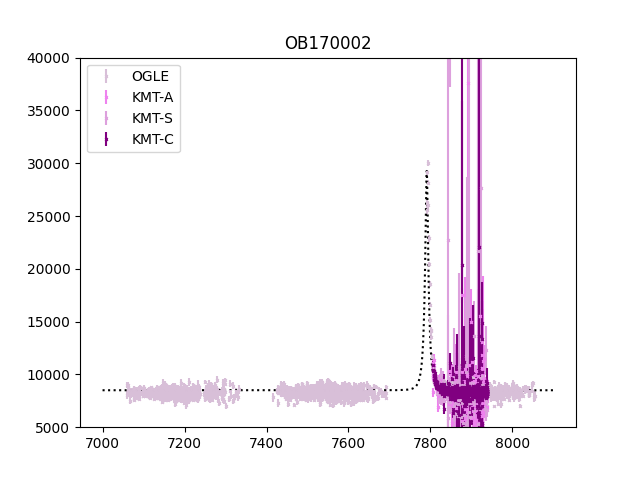

In [25]:
t0, u0, tE, rho = 7790.87236, 0.3, 12, 0.01 # use the fit value from exercise 5!!
Theta0 = np.array([t0, u0, tE, rho])  # initial guess
labels = np.array(['t_0', 'u_0', 't_E', 'rho']) # parameter labels

OB170002_fspl = MulensModel.Model({'t_0': t0, 'u_0': u0, 't_E': tE, 'rho': rho}) 

# setting the magnification method
OB170002_fspl.set_magnification_methods([2450000., 'finite_source_uniform_Gould94', 2470000.]) # rho <= 0.1

plt.figure(12)
t = np.linspace(7000, 8100, 2000)  # time range
A0 = OB170002_fspl.get_magnification(t)  # initial guess magnification curve
plt.plot(t, A0*8500, label='Initial Guess', color='black', linestyle=':')
plt.show()

We combine these in an Event object.

Initial Parameter Guess:
    t_0 (HJD)       u_0    t_E (d)     rho 
   7790.87236  0.300000    12.0000 0.01000 


/home/katarzyna/Documents/mini_courses/.guide_venv/lib/python3.11/site-packages/MulensModel/fitdata.py:63: UserWarning: Dataset bandpass is I but model does not have a limb-darkening coefficient for I. Assuming zero.
  warnings.warn(msg.format(self.dataset.bandpass))
/home/katarzyna/Documents/mini_courses/.guide_venv/lib/python3.11/site-packages/MulensModel/utils.py:147: UserWarning: Flux to magnitude conversion approached negative flux
  warnings.warn(
/home/katarzyna/Documents/mini_courses/.guide_venv/lib/python3.11/site-packages/MulensModel/utils.py:150: RuntimeWarning: invalid value encountered in log10
  mag = zeropoint - 2.5 * np.log10(flux)
/home/katarzyna/Documents/mini_courses/.guide_venv/lib/python3.11/site-packages/MulensModel/mulensdata.py:504: UserWarning: Some good data points have scaled errorbars with negative values. Setting them to zero for plotting.
Dataset: KMT-A
Epochs: [7910.31023]
  warnings.warn(msg.format(kind, self._get_name(), self.time[indexes]))


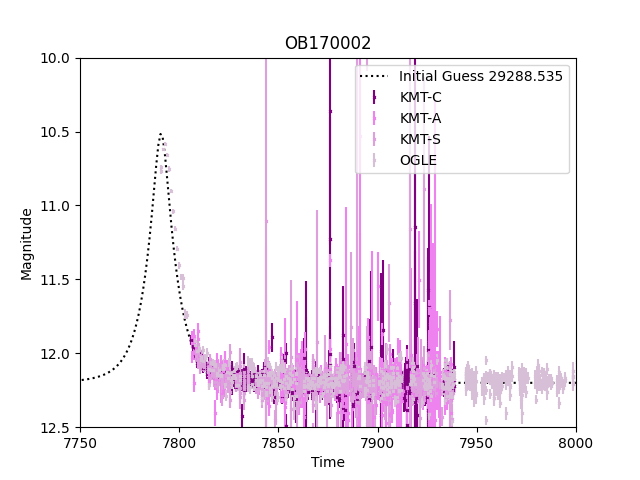

In [26]:
OB170002 = MulensModel.Event(datasets=OB170002_data, model=OB170002_fspl)

def chi2_fun(theta, parameters_to_fit, event):
    """
    Calculate chi2 for given values of parameters.
    
    Parameters
    ----------
    theta : np.ndarray
        Vector of parameter values, e.g., `np.array([5380., 0.5, 20.])`.
    parameters_to_fit : list of str
        List of names of parameters corresponding to theta, e.g., `['t_0', 'u_0', 't_E']`.
    event : MulensModel.Event
        Event which has datasets for which chi2 will be calculated.
    
    Returns
    -------
    chi2 : float
        Chi2 value for given model parameters.
    
    Notes
    -----
    Function from MulensModel documentation: 
    https://github.com/rpoleski/MulensModel/blob/master/examples/example_02_fitting.py
    """
    # First we have to change the values of parameters in
    # event.model.parameters to values given by theta.
    for (parameter, value) in zip(parameters_to_fit, theta):
        setattr(event.model.parameters, parameter, value)

    # After that, calculating chi2 is trivial:
    return event.get_chi2()

print('Initial Parameter Guess:\n{0}'.format(OB170002.model.parameters))

plt.close(13)
plt.figure(13)

chi20 = chi2_fun(Theta0, labels, OB170002)  # initial guess chi2
OB170002.plot_model(color='k', label='Initial Guess %1.3f' %chi20, linestyle=':', t_range=[7000, 8100])
OB170002.plot_data()  # MulensModel automatically fits for the source and blend flux for the  
# given model.

plt.legend(loc='best')
plt.title('OB170002')
plt.ylim(12.5, 10)
plt.xlim(7750,8000)
plt.show()

<div style="background-color:#e0e0e0; 
    border-left: 8px solid #808080; 
    padding: 10px 0 10px 20px; 
    margin: 20px 5px; 
    box-sizing: border-box"> <a href="./Exercises/SingleLensE7.txt">
    <h2 style="color: #808080; font-size: 24px;">Exercise 7</h2>
    </a>
    <p>1. What is the angular size of the source in event OB170002?</p>
    <br>
    <p>2. How much did the addition of a finite source parameter in the model increase the relative probabilty of your model generating the observed data?</p>
    <br>
    <p>3. Why does it not make sense for your relative probability to have decreased?</p>
</div>

> <i>If your probability does decrease with an increase in the complexity of your model, this is an indication that your minimisation method is failing somehow. We refer you to the [Modelling](Modelling.ipynb) notebook for a better understanding of the topic.</i>

In [ ]:
######################
# E7.1 Write your model fitting code here
######################

In [ ]:
######################
# E7.2 Do your working here
######################

#### E7.3 Why does it not make sense for your relative probability to have decreased?

Write you answer here

Smashed it! Good job. I have nothing more to teach you, Grasshoper.

## Next steps

Microlensing modelling is riddled with degeneracies. If we want to gain more understanding about the physical make-up of our event bodies (i.e. size, mass, distance) then we need more information through either the modelling of higher-order effects, follow-up observations, or both. Failing that, we can use baysian statistics to determine the most likely physical parameters for an event. If you are interested in determing physical parameters from microlensing events proceed to the following notebooks:

+ [Higher Order Effects](HigherOrderEffect.ipynb) (in preperation),
+ [Physical Parameters](PhysicalParameters) (in preperation),
+ [Astrometric Follow-up](LensFluxAnalysis.ipynb) (in development).

If you are interested in binary lens events (e.g., for exoplanet detection), you should consider both of the following notebooks:

+ [Binary Sources](BinarySources.ipynb),
+ [Binary Lenses](BinaryLens.ipynb) (in development),

However, It would be best if you eventually completed these as well
+ [Higher Order Effects](HigherOrderEffect.ipynb) (in preperation),
+ [Physical Parameters](PhysicalParameters) (in preperation),
+ [All the Lenses](MultipleLens.ipynb) (in preperation).

Microlensing events, particularly multiple lens events, have notoriously stochastic likelihood landscapes. This can challange more basic modelling minimisation methods such as the Nelder-Mead method used in this notebook. If you intend to fit microlensing events with more than one lens, or are interested in bayesian posteriors for you fits, we recommend you also check out the [Modelling](Modelling.ipyng) notebook.